### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%matplotlib inline
#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


/Users/andreas/phys/master/FERMI/venv/lib/python3.7/site-packages/stingray/largememory.py:26: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  "Large Datasets may not be processed efficiently due to "


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
36 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 54 flags
Removed 54 flags from df
df sorted by tus
2019-03-05 13:05:19.816318
first tus:  -720406.7222222222 | max tus:  1288231.9166666667
13456
tus array OK ...


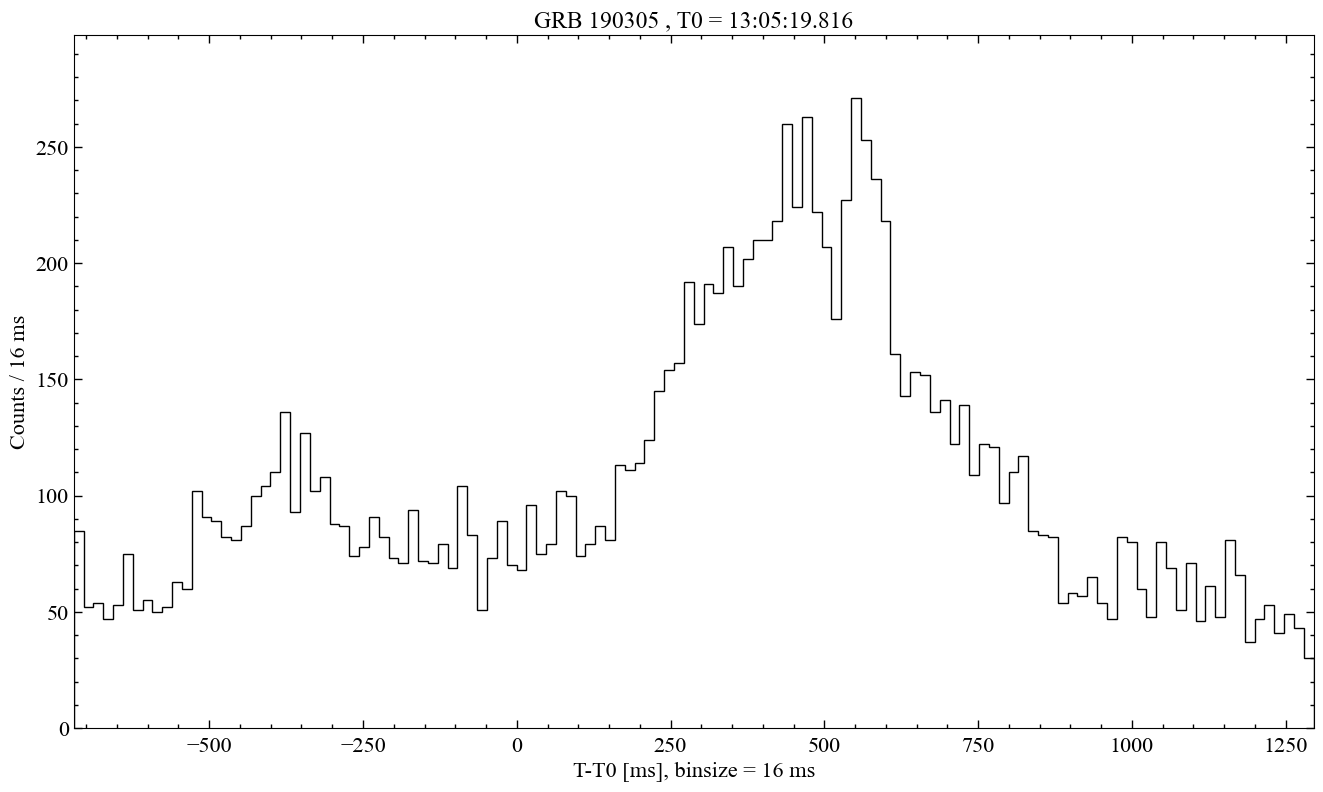

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB190305",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=16)

In [8]:
# Looks like 500 ms delay of signal in ASIM tus
# --> tlag_approx = +0.5 s
#Burst last around 1.5 s

# tlagg approx

In [6]:
#calculating the tlagg approx based on trigger times and ToF
#bringing into KW ref frame...
#T0_ASIM = 13:05:19.816 abs time correction accounted for
#T0_KW = 13:05:15:900
#ToF = 3.4460
tlagg_approx = np.round(19.816-15.900-3.4460,3)
print(tlagg_approx)

0.47


## KW

-0.25
1.504


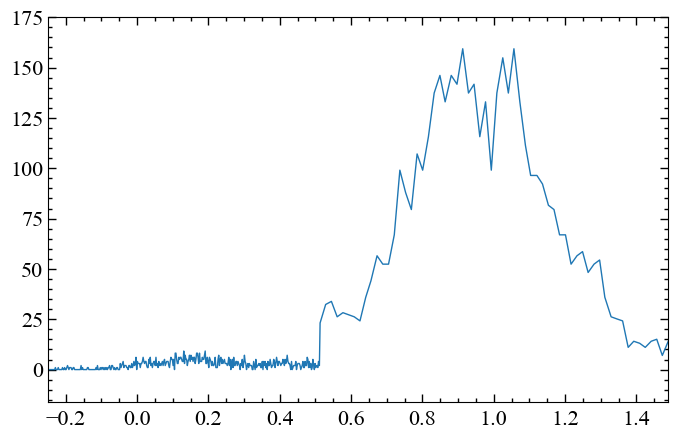

In [51]:
kw_filename = "GRB190305A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

#kw_dt = np.round(np.diff(kw_bin_lo),3)
#i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

#cutting LC at T0+1.5 s, so that both LC's have 2s of data
i_start_kw = find_nearest(kw_bin_lo,-0.25)
print(kw_bin_lo[i_start_kw])
i_stop_kw = find_nearest(kw_bin_lo,1.5)
print(kw_bin_lo[i_stop_kw])


kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[i_start_kw:i_stop_kw], kw_bin_hi[i_start_kw:i_stop_kw], G1[i_start_kw:i_stop_kw],G2[i_start_kw:i_stop_kw], G3[i_start_kw:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

kw_lc.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 181222B KW 300-1160 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorrelation/KW_originalLC.png")

# Notes on ASIM LC
    Very short interval to estimate the background! ~250 ms
    No need to estimate background for the CC
    Maybe start the CC from -0.25s. Have no data for HED before -0.25s
        >> Checking firts if it is necc. to cut before this time ...
        >> CC suggest moving one 16ms bin in + direction --> tlagg ~0.486
        >> Cutting KW and ASIM at t_start=-0.256s doesn't change the CC
    
    Starting CC with 2 ms binsize to see if there is any improvement
        >> Easier to visually see where the burst starts
        >> New tlagg = 0.472s

### ASIM prep

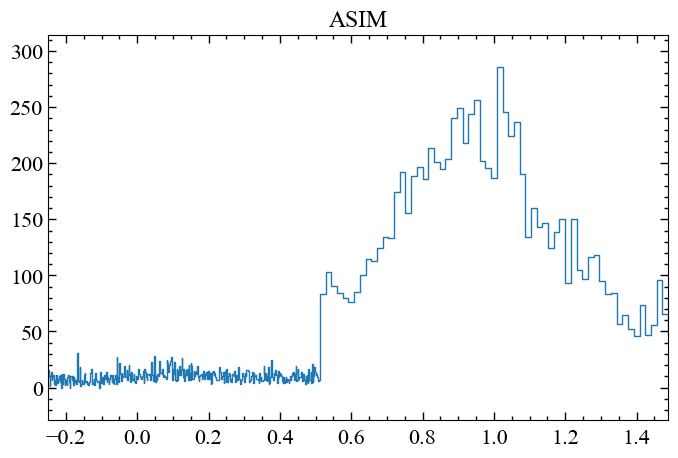

In [52]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32) # keeping all counts! No keV filter needed
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds 

tus += tlagg_approx
#asim_binsOrg = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
hist = np.histogram(tus,bins=np.append(kw_bin_lo,kw_bin_hi[-1])) #using KW bins
asimCounts,asimEdges = hist[0],hist[1]

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM")
plt.show()

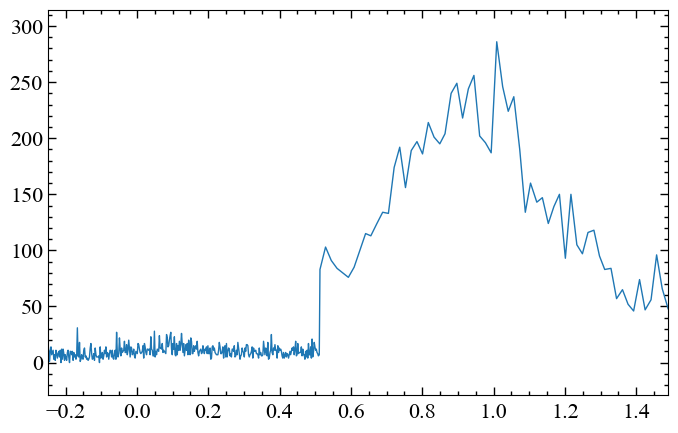

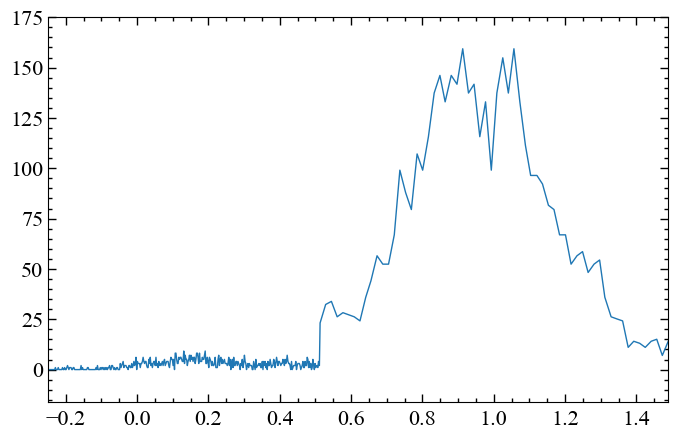

In [53]:
asim_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=asimCounts, skip_checks=True,dt=binsize)
asim_lc.plot()
kw_lc.plot()

Total lagg (s):  0.472 | CC lagg:  0.002   tlagg_approx:  0.47


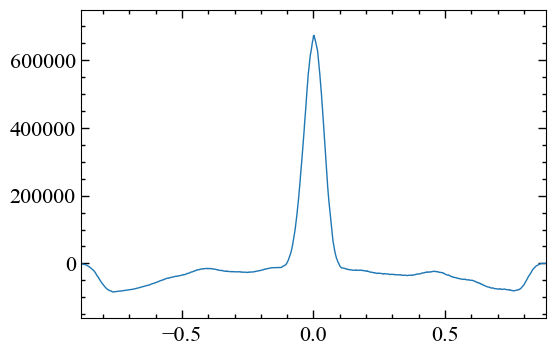

<AxesSubplot:>

In [54]:
CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg, '  tlagg_approx: ', tlagg_approx)
CC.plot()

### LC approx compare and tlagg

kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asim_lc=asimLC,binsize=binsize)
#CompareLC actually cuts correctly kw if asim LC is "short"
CC = CrossCorrelation(kwCompare,asimCompare,mode="full")
CClagg=CC.time_shift
tlagg = laggApprox + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
kwFinal,asimFinal = CompareLC(kw_lc=kw_lc,asim_lc=asimLC.shift(CClagg),binsize=binsize,okReturn=True)

### Approx shift

T0_approx = T0_ASIM+timedelta(seconds=laggApprox)

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare),label="ASIM shifted by {} s, \n 300-1160 keV".format(np.round(laggApprox,3)))
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare),c="r",alpha=0.6,label="KW 300-1160 keV")

plt.title("GRB 181222B normalized ASIM/KW light curve")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {} ".format(T0_KW.isoformat(timespec='milliseconds')),alpha=0.6,linestyle="--")
plt.legend()
plt.ylim(bottom=0,top=1.1)
plt.xlim(left=-0.2,right=0.4)
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorrelation/ASIM_KW_AppShift.png")
plt.show()

plt.plot(CC.time_lags,CC.corr,label="tlagg approx: {} s \n tlagg from CC: {} s \n Total tlagg {} s".format(np.round(laggApprox,3), np.round(CClagg,3), np.round(tlagg,3)))
plt.title("GRB181222B ASIM/KW Cross Correlation")
plt.xlabel('Time Lags (seconds) after -0.8 s time shift')
plt.ylabel('Correlation')
plt.legend()
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorrelation/CC_asim_kw.png")
plt.show()

### Final LC

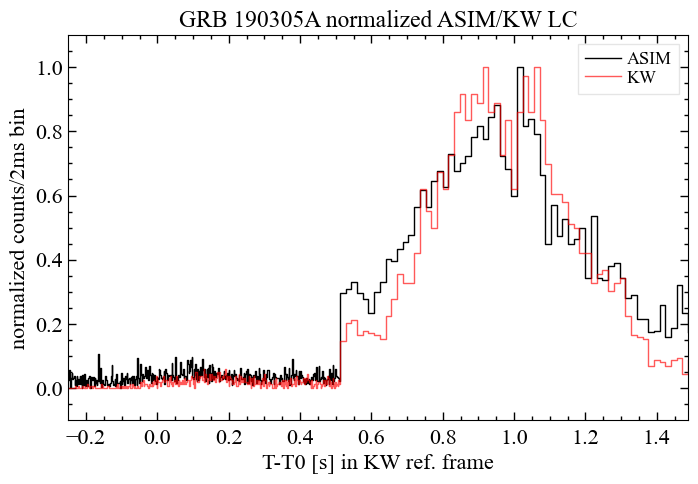

In [57]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds

tus += tlagg #optimal tlagg:

hist = np.histogram(tus,bins=np.append(kw_bin_lo,kw_bin_hi[-1]))
asimCounts,asimEdges = hist[0],hist[1]

#iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
#iAsimBkgEnd = find_nearest(asimEdges,-0.25)
#asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
#print("asimBkg: ",asimBkg)
#for i,count in enumerate(asimCounts):
#    if count-asimBkg <= 0:
#        asimCounts[i] = 0
#    else:
#        asimCounts[i] -= asimBkg


plt.step(x=asimEdges[:-1],y=asimCounts/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)

plt.title("GRB 190305A normalized ASIM/KW LC")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")

#plt.xlim(left=-0.1,right=0.2)
#plt.ylim(bottom=0,top=1.2)
#plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB201227A/CrossCorrelation/overlappingLC_asim_kw.png")
plt.legend()
plt.show()
#16ms binsize: Good Cross Correlation with tlagg=+0.486s applied to ASIM
#2ms binsize: Even better CC with tlagg=+0.472s applied to ASIM

# Fits files

In [48]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb

In [59]:
print(tlagg) #[s] 2ms binsize: tlagg=+0.472, 16ms binsize: tlagg=+0.486s

0.472


## event

In [60]:
ASIM_df,T0 = complete_df(grb_id="GRB190305",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
36 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 54 flags
Removed 54 flags from df
df sorted by tus


tus array OK ...


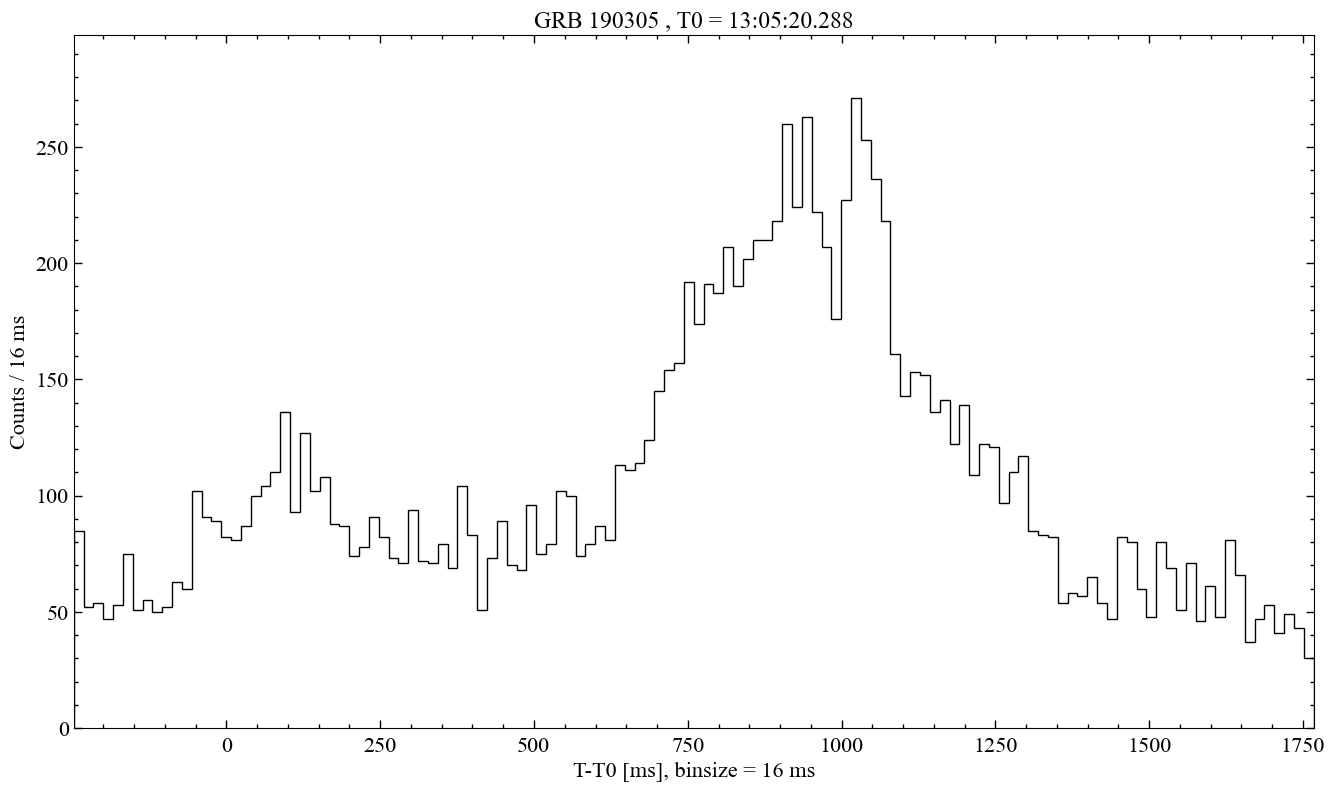

In [63]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=16)

In [ ]:
keV_df,tus_check = keV_hist(df=ASIM_df,time_interval=(0,0.064), #need correct time interval
                  keV_interval="max",
                  check_LC = True)

In [ ]:
plot_HED(tus_arr=tus_check*1e6,T0=T0_shift,binsize=2)

### bg estimation

In [ ]:
keV_bg,bg_check = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.1),
                 keV_interval="max",
                 check_LC=True)

In [ ]:
plot_HED(tus_arr=bg_check*1e6,T0=T0_shift,binsize=2)

## fits 

In [51]:
T0_shift.isoformat()

'2018-12-22T20:11:35.721228'

### PHA

In [ ]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:35.721','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [?,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [?,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [312.572,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.240,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB181222.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB181222.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB181222.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's


In [ ]:
bin_lo = keV_df['bins_keV'].to_numpy()[:-1]
bin_hi = keV_df['bins_keV'].to_numpy()[1:]
counts = keV_df['counts'].to_numpy()[1:]
err = keV_df['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

In [ ]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK

In [ ]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:35.721','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.9,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.1,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.8,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [312.572,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.240,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB181222.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [ ]:
bak_counts = keV_bg['counts'].to_numpy()[1:]
bak_err = keV_bg['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [ ]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2018-12-22T20:11:35.721','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [?,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [?,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB181222B','Name of the observed object'], #<str> 
    'RA_OBJ': [312.572,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [24.240,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB181222.rsp','RSP filename'] #<str>  ('example.pha')
}

In [54]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

In [57]:
theta,phi = 100.622,-49.011 #theta, phi angles for the incomming radiation reaching the ISS
drm_path = '/Users/andreas/phys/master/HED_DRM/'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_105.00_-45.00.txt


In [ ]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)